In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from matplotlib import cm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyClassifier
from wordcloud import WordCloud
from nltk.probability import FreqDist
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
pd.set_option('display.max_columns', None)
plt.style.use('fivethirtyeight')
params = {'legend.fontsize': 'medium',
          'figure.figsize': (8, 5),
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small',
          'lines.linewidth' : 1.6}
plt.rcParams.update(params)
import string, re
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /Users/singh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/singh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/singh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
df = pd.read_csv('tweet.csv',  encoding= 'unicode_escape')

In [3]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


## Data Preprocessing

In [5]:
df.rename(columns = {'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion'}, inplace = True)

In [6]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [7]:
df.isna().sum()

tweet_text                            1
emotion_in_tweet_is_directed_at    5802
emotion                               0
dtype: int64

### Removing the row where tweet text is missing 

In [8]:
df.dropna(subset = ['tweet_text'], inplace = True)

In [9]:
df.isna().sum()

tweet_text                            0
emotion_in_tweet_is_directed_at    5801
emotion                               0
dtype: int64

In [10]:
df.emotion.value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: emotion, dtype: int64

### Removing "I can't tell" 

In [11]:
df.drop(df[df['emotion'] == 'I can\'t tell'].index, inplace = True)

In [12]:
df.emotion.value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
Name: emotion, dtype: int64

### Changing 'No emotion toward brand or product' to Neutral

In [13]:
df['emotion'] = np.where(df['emotion'] == 'No emotion toward brand or product', 'Neutral Emotion', df['emotion'])

df['emotion'].value_counts()

### Creating a column for company

In [14]:
df.emotion_in_tweet_is_directed_at.value_counts()

iPad                               942
Apple                              659
iPad or iPhone App                 470
Google                             429
iPhone                             296
Other Google product or service    292
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [15]:
df.emotion_in_tweet_is_directed_at.isna().sum()

5654

In [16]:
def get_company(row):
    if row['emotion_in_tweet_is_directed_at'] is np.nan:
        return np.nan
    if 'Apple' in row['emotion_in_tweet_is_directed_at'] or 'iPhone' in row['emotion_in_tweet_is_directed_at'] or 'iPad' in row['emotion_in_tweet_is_directed_at']:
        return 'Apple'
    else:
        return 'Google'

In [17]:
df['company'] = df.apply(get_company, axis = 1)

In [18]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,emotion,company
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Apple
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Apple
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,Apple
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,Apple
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,Google


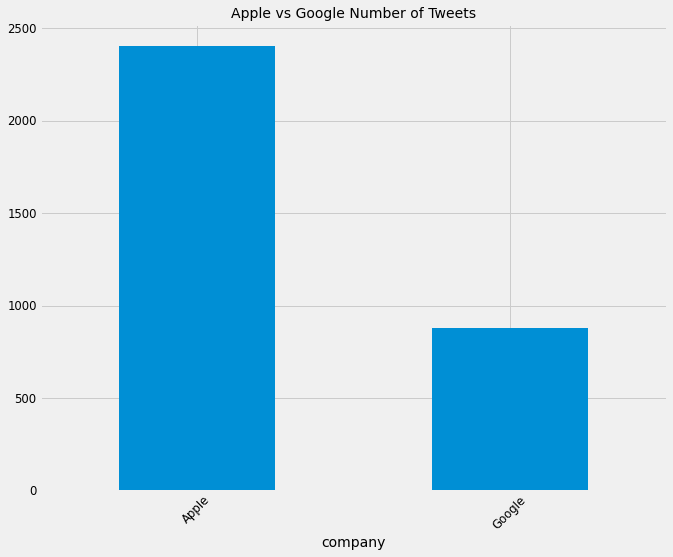

In [19]:
plt.figure(figsize=(10,8))
df.groupby('company').company.count().plot(kind = 'bar')
plt.xticks(rotation=45)
plt.title('Apple vs Google Number of Tweets')
plt.show()


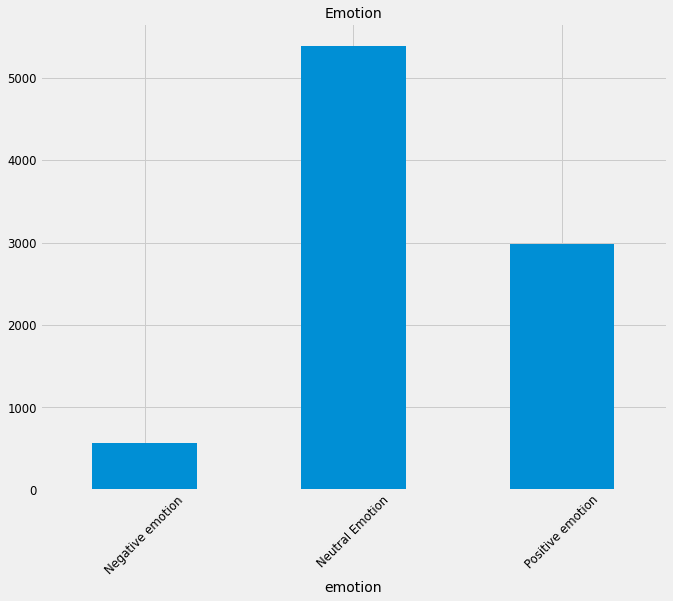

In [20]:
plt.figure(figsize=(10,8))
df.groupby(['emotion']).emotion.count().plot(kind = 'bar')
plt.xticks(rotation=45)
plt.title('Emotion')
plt.show()

<Figure size 720x576 with 0 Axes>

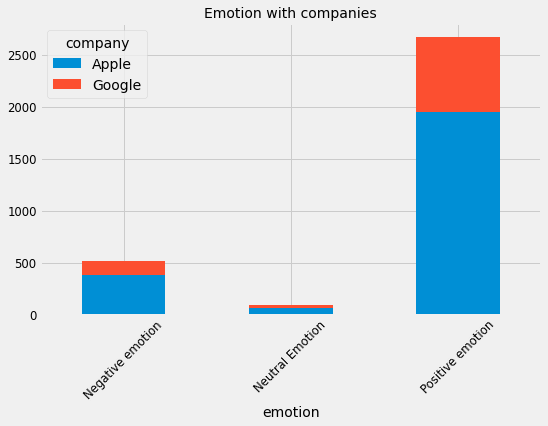

In [21]:
plt.figure(figsize=(10,8))
df.groupby(['emotion', 'company']).company.count().unstack().plot(kind = 'bar', stacked = True)
plt.xticks(rotation=45)
plt.title('Emotion with companies')
plt.show()

<Figure size 720x576 with 0 Axes>

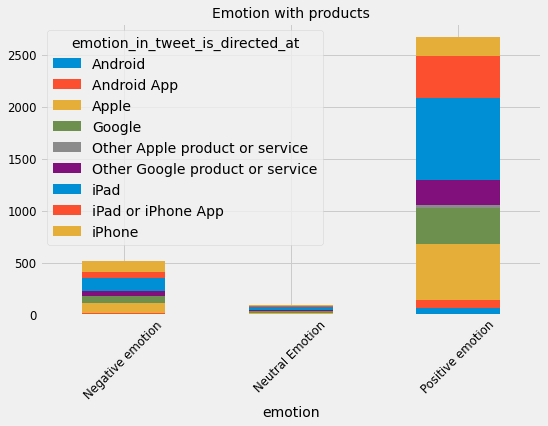

In [22]:
plt.figure(figsize=(10,8))
df.groupby(['emotion',  'emotion_in_tweet_is_directed_at']).emotion.count().unstack().plot(kind = 'bar', stacked = True)
plt.xticks(rotation=45)
plt.title('Emotion with products')
plt.show()

In [23]:
df['emotion'] = np.where(df['emotion'] == 'Negative emotion', 0 ,df['emotion'])
df['emotion'] = np.where(df['emotion'] == 'Neutral Emotion', 1 ,df['emotion'])
df['emotion'] = np.where(df['emotion'] == 'Positive emotion', 2 ,df['emotion'])
                    

In [24]:
data = df['tweet_text']
target = df['emotion']

In [25]:
## setting stopwords and punctuations
sw_list = stopwords.words('english')
sw_list += list(string.punctuation)
sw_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘',
           'apple', 'iphone', 'ipad', 'google', 'android', 'sxsw',
           '\'s', '2', 'rt']
sw_set = set(sw_list)


In [26]:
# we can define a function that removes stopwords 
def process_tweet(tweet):
    tokens = nltk.word_tokenize(tweet)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in sw_set]
    return stopwords_removed 

#### Most Frequent Words

In [27]:
df_negative = df[df['emotion'] == 0]
df_neutral = df[df['emotion'] == 1]
df_positive = df[df['emotion'] == 2]

In [28]:
data_negative = df_negative['tweet_text']
data_neutral = df_neutral['tweet_text']
data_positive = df_positive['tweet_text']

In [29]:
pros_negative = list(map(process_tweet, data_negative))
pros_neutral = list(map(process_tweet, data_neutral))
pros_positive = list(map(process_tweet, data_positive))

In [30]:
flat_negative = [item for sublist in pros_negative for item in sublist]
flat_neutral = [item for sublist in pros_neutral for item in sublist]
flat_positive = [item for sublist in pros_positive for item in sublist]

In [31]:
negative_freq = FreqDist(flat_negative)
neutral_freq = FreqDist(flat_neutral)
positive_freq = FreqDist(flat_positive)

In [32]:
negative_freq.most_common(20)

[('mention', 313),
 ('quot', 175),
 ('link', 102),
 ("n't", 87),
 ('app', 60),
 ('store', 46),
 ('new', 43),
 ('like', 39),
 ('circles', 34),
 ('social', 31),
 ('apps', 30),
 ('people', 29),
 ('design', 28),
 ('need', 25),
 ('austin', 24),
 ('get', 24),
 ('one', 23),
 ('amp', 22),
 ('launch', 22),
 ('would', 21)]

In [33]:
neutral_freq.most_common(20)

[('mention', 4513),
 ('link', 2946),
 ('quot', 1018),
 ('store', 867),
 ('new', 678),
 ('austin', 630),
 ('amp', 601),
 ('circles', 490),
 ('social', 481),
 ('launch', 465),
 ('today', 441),
 ('app', 355),
 ('network', 355),
 ('called', 277),
 ('via', 271),
 ('free', 260),
 ('line', 249),
 ('pop-up', 247),
 ('ipad2', 233),
 ('sxswi', 230)]

### Visualization of most frequent words

In [34]:
# create counts of negative, neutral and positive with values and words
negative_bar_counts = [x[1] for x in negative_freq.most_common(30)]
negative_bar_words = [x[0] for x in negative_freq.most_common(30)]

neutral_bar_counts = [x[1] for x in neutral_freq.most_common(30)]
neutral_bar_words = [x[0] for x in neutral_freq.most_common(30)]

positive_bar_counts = [x[1] for x in positive_freq.most_common(30)]
positive_bar_words = [x[0] for x in positive_freq.most_common(30)]

In [35]:
# set the color of our bar graphs
color = cm.viridis_r(np.linspace(.4,.8, 30))

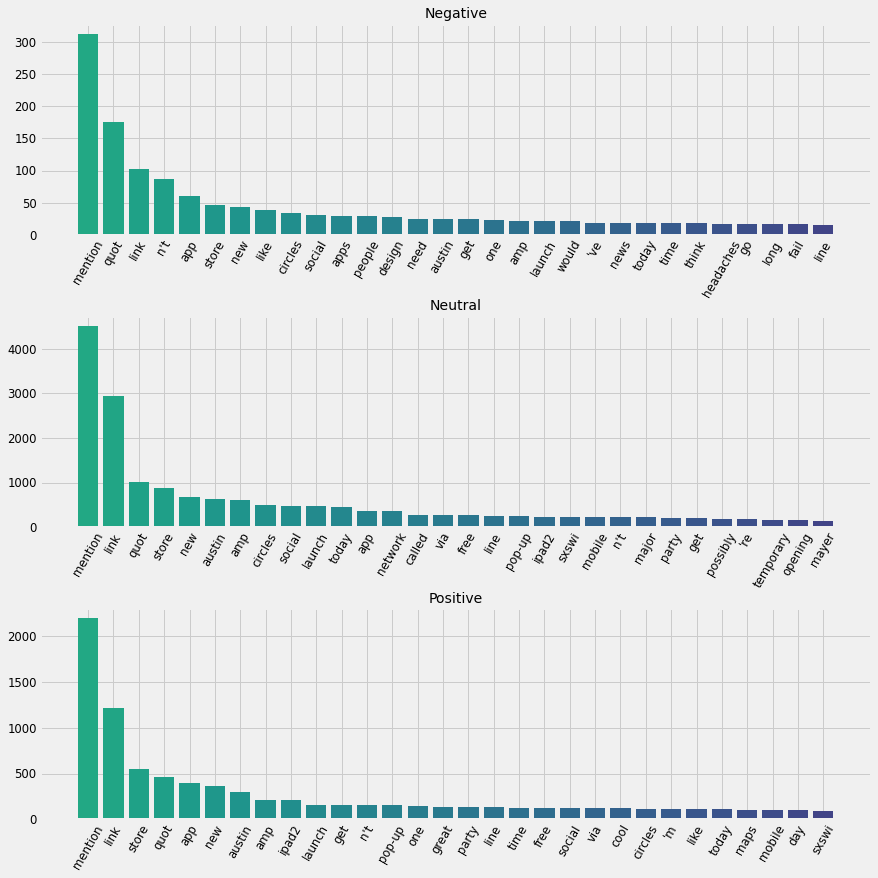

In [36]:
new_figure = plt.figure(figsize=(12,12))

ax = new_figure.add_subplot(311)
ax2 = new_figure.add_subplot(312)
ax3 = new_figure.add_subplot(313)

# Generate a line plot on first axes
ax.bar(negative_bar_words, negative_bar_counts, color=color)
# ax.plot(colormap='PRGn')

# Draw a scatter plot on 2nd axes
ax2.bar(neutral_bar_words, neutral_bar_counts, color=color )

# Draw a scatter plot on 2nd axes
ax3.bar(positive_bar_words, positive_bar_counts, color=color )

ax.title.set_text('Negative')
ax2.title.set_text('Neutral')
ax3.title.set_text('Positive')

for ax in new_figure.axes:
    plt.sca(ax)
    plt.xticks(rotation=60)

plt.tight_layout(pad=0)

# plt.savefig('word count bar graphs.png')

plt.show()

## Word Clouds

In [37]:
negative_dictionary = dict(zip(negative_bar_words, negative_bar_counts))
neutral_dictionary = dict(zip(neutral_bar_words, neutral_bar_counts))
positive_dictionary = dict(zip(positive_bar_words, positive_bar_counts))

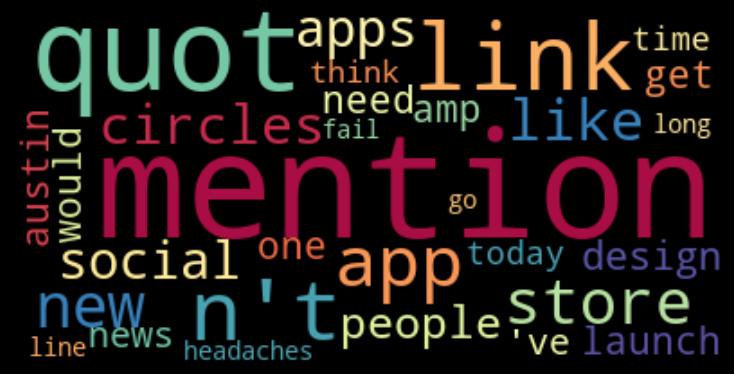

In [38]:
# Create the word cloud:

wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(negative_dictionary)

# Display the generated image w/ matplotlib:

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

# Uncomment the next line if you want to save your image:
# plt.savefig('satire_wordcloud.png')

plt.show()

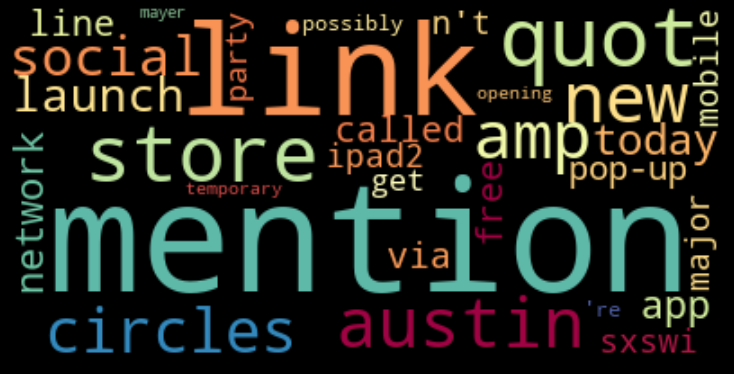

In [39]:
# Create the word cloud:

wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(neutral_dictionary)

# Display the generated image w/ matplotlib:

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

# Uncomment the next line if you want to save your image:
# plt.savefig('satire_wordcloud.png')

plt.show()

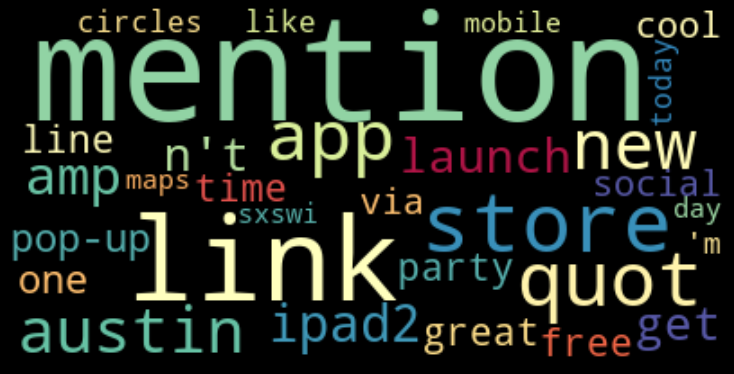

In [40]:
# Create the word cloud:

wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(positive_dictionary)

# Display the generated image w/ matplotlib:

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

# Uncomment the next line if you want to save your image:
# plt.savefig('satire_wordcloud.png')

plt.show()

## Modeling

In [41]:
# applying the above function to our data/features 
processed_data = list(map(process_tweet, data))

In [42]:
lemmatized_output = []
lemmatizer = WordNetLemmatizer() 
for listy in processed_data:
    lemmed = ' '.join([lemmatizer.lemmatize(w) for w in listy])
    lemmatized_output.append(lemmed)

In [43]:
lemmatized_output[:5]

['wesley83 3g 3 hr tweeting rise_austin dead need upgrade plugin station',
 "jessedee know fludapp awesome ipad/iphone app 'll likely appreciate design also 're giving free t",
 'swonderlin wait also sale',
 "hope year festival n't crashy year app",
 "sxtxstate great stuff fri marissa mayer tim o'reilly tech books/conferences amp matt mullenweg wordpress"]

In [44]:
X_lem = lemmatized_output
y_lem = target

In [85]:
y_lem = y_lem.astype(int)

In [86]:
y_lem

0       0
1       2
2       2
3       0
4       2
       ..
9088    2
9089    1
9090    1
9091    1
9092    1
Name: emotion, Length: 8936, dtype: int64

## Bag Of Words

In [91]:
cv = CountVectorizer()
cvv = cv.fit_transform(X_lem)
cv_df = pd.DataFrame(cvv.toarray().transpose(), index = cv.get_feature_names()).transpose()


In [ ]:
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(cv_df, y_lem, test_size=0.20, random_state=1)

## Dummy Classifier Baseline Model

In [103]:
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train_lem, y_train_lem)
dummy_clf.predict(X_train_lem)
dummy_clf.score(X_train_lem, y_train_lem)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "


0.4731393396754337

## Logistic Regression

In [101]:
lr_weighted = LogisticRegression(solver='newton-cg',class_weight = 'balanced',  n_jobs = -1, verbose = 1)
lr_weighted.fit(X_train_lem, y_train_lem)

y_weighted_train = lr_weighted.predict(X_train_lem)
y_weighted_test = lr_weighted.predict(X_test_lem)

f1_train = metrics.f1_score(y_train_lem, y_weighted_train, average='weighted')
f1_test = metrics.f1_score(y_test_lem, y_weighted_test, average='weighted')
print('Test Accuracy score: ', metrics.accuracy_score(y_test_lem, y_weighted_test))
print('Train F1 score: ', f1_train)
print('Test F1 score: ', f1_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  3.6min finished


Test Accuracy score:  0.6700223713646533
Train F1 score:  0.8941666473327604
Test F1 score:  0.6729694023551364


In [105]:
confusion_matrix(y_test_lem, y_weighted_test)

array([[ 51,  43,  19],
       [ 60, 794, 230],
       [ 28, 210, 353]])

## Random Forest

In [111]:
rfc = RandomForestClassifier(random_state = 1,
                             n_estimators = 1000,
                             max_depth = 10,
                             n_jobs = -1,
                             class_weight = 'balanced',
                             verbose = 1)
rfc.fit(X_train_lem, y_train_lem)

rfc_train = rfc.predict(X_train_lem)
rfc_test = rfc.predict(X_test_lem)

rfc_f1_train = metrics.f1_score(y_train_lem, rfc_train, average='weighted')
rfc_f1_test = metrics.f1_score(y_test_lem, rfc_test, average='weighted')
print('Test Accuracy score: ', metrics.accuracy_score(y_test_lem, rfc_test))
print('Train F1 score: ', rfc_f1_train)
print('Test F1 score: ', rfc_f1_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   36.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s


Test Accuracy score:  0.5866890380313199
Train F1 score:  0.6986506061966595
Test F1 score:  0.6028075495767575


[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.3s finished


In [112]:
confusion_matrix(y_test_lem, rfc_test)

array([[ 63,  21,  29],
       [129, 667, 288],
       [ 70, 202, 319]])

## tfidf 

In [115]:
tfidf = TfidfVectorizer()
tfidff = tfidf.fit_transform(X_lem)
tfidf_df = pd.DataFrame(tfidff.toarray().transpose(), index = tfidf.get_feature_names()).transpose()


In [117]:
tfidf_df.head()

,00,000,00am,00pm,01am,02,03,0310apple,06,08,10,100,100tc,101,106,10am,10k,10mins,10pm,10x,10x2,11,1100,1154,11am,11bil,11ntc,11p,11pm,11th,12,120,1223,125,128,12ab,12am,12b,12bn,12th,13,130,1300,1315,14,1406,1408,141164002609303,1413,1415,141st,1422,1443,14th,15,150,1500,150m,150mm,157,15am,15k,15pm,15slides,16,16162,165,169,16gb,16mins,17,18,1850,188,19,1980,1980s,1985,1986,1990style,1991,1k,1m,1of,1pm,1st,20,200,2009,200m,2010,2011,2012,206,206k,21,210,2100,214,22,220,222,22sxsw,23,230,24,24587,25,250,250k,25th,26svo3m,27,270,285,29,2am,2b,2day,2g,2h,2honor,2moro,2nd,2nite,2rd,2wk,2wks,2x,2yrs,2åê,30,300,3000,30a,30am,30k,30min,30mio,30p,30pm,30th,31,310409h2011,313,32,32000,32g,32gb,33,330,330pm,35,350,36,360,360idev,365plusmedia,37,38,39,3am,3bil,3blks,3d,3g,3gs,3k,3pm,3rd,3x,40,400,40min,41,420,43,437,44,45,450,457,45am,45bil,45pm,47,48,49,49n4m,4am,4android,4chan,4chan4eva,4g,4hb,4nqv92l,4pm,4sq,4sq3,4sqchat,4square,4sqwill,4th,4this,50,500,5000,504,512,54,55,58,59,59a,59p,59pm,5am,5hrs,5min,5pm,5th,60,600,605,60secondcrush,615ab,63,64,64g,64gb,64gig,64mb,65,66,68,681,69,699,6gjmypj,6hours,6pm,6th,6thish,6thst,6thstreet,70,72296,73,7322,75,779,78,7pm,7th,80,800,80s,81,812,82,829,83323324,83323414,83881586,85,86,88,8800,89,8a,8am,8p,8pm,8th,90,900,90999,911,911tweets,930a,95,96,967,97,98,99,99å,9abc,9th,9to5,__,___,_____,______,_______,_and_,_really_,_µ,_¼,_ã,_ô,a11y2go,a3xvwc6,aapl,aaron,aarpbulletin,ab,abacus,abandoned,abba,aber,ability,able,abnormal,abound,about,abroad,absolute,absolutely,absolutley,abt,abuzz,academy,acc,accelerater,acceleration,accelerator,accept,acceptable,access,accessibility,accessible,accessory,accesssxsw,accidentally,accommodate,accompanied,accomplish,according,accordion,account,accuracy,acerbic,achieve,achievement,acknowledge,ackward,aclu,aclus,acoustic,acquired,acquisition,across,acrosse,act,acting,action,actionable,activate,activation,activity,actor,actsofsharing,actual,actually,ad,adam,adapt,adapter,adapting,adaptive,add,added,addict,addicted,addictedtotheinterwebs,addiction,addictive,adding,addition,additional,addr,address,adele,adfonic,adi,adloopz,admired,admission,admit,admits,admitting,admob,ado,adobe,adopter,adoption,adpeopleproblems,advance,advanced,advantage,advent,adventure,advertising,advice,advil,advising,advisory,advocate,adwords,ae,aesthetic,afar,affair,affect,affiliated,affirmative,afford,afraid,africa,african,after,afternoon,afteward,aftrnoon,agchat,age,agency,agenda,agent,aggregated,aggregator,agileagency,agility,agnerd,ago,agree,agreed,ah,aha,ahead,ahem,ahh,ahhh,ahi,ahing,ahold,ahoy,ai,aicn,aid,aiding,aight,aim,air,airline,airplane,airport,airports,aisle,ajax,ajs2011,aka,akabuzz,akhirnya,akqa,akqas,al,ala,alamo,alan,alarm,albany,album,alcohol,alcoholic,alert,alex,algorithm,alguien,alice,alien,alignd,aligned,alisa,alive,all,allcomfortfooddiet,allen,alley,allhat,allhat3,allow,allowing,allows,allshare,allthingsd,almedia,almost,alone,along,alot,alpha,alphabetically,alphagraphics,already,alright,also,alt,alternate,alternative,although,altimeter,alto,alumnus,always,alwayshavingtoplugin,amalgamation,amateurhour,amazes,amazing,amazingly,amazon,ambassador,amble,amen,amer,america,american,american_statesman,amex,amhealth,ami,amid,amigo,amismarternow,amiss,among,amoral,amount,amp,ample,amplifiedlife,amused,amusing,amy,an,analog,analogy,analysis,analytics,anatomy,and,andoid,andrew,andriod,andro,android,androidcrunch,androiddev,androidhig,androidsxsw,andy,angel,angry,angrybirds,animated,animation,anna,anniemal,announce,announced,announcement,announces,announcing,annoyed,annoying,annuncia,anonymity,anonymous,anoth,another,answer,answered,answering,answr,anti,anticipate,anticipation,antigov,antique,antonio,antwoord,anxiety,anxious,anybody,anybodywanttobuymeanipad2,anymore,anyone,anyones,anything,anyway,anyways,anywhere,anz,aol,aos,ap,apaan,apac,apart,apartment,apartmovie,ape,aphone,api,apis,apology,app,apparent,apparently,appcircus,appeal,appealing,appear,appearance,appeared,appears,appen,a

In [118]:
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(tfidf_df, y_lem, test_size=0.20, random_state=1)

### Logistic Regression

In [119]:
lr_weighted = LogisticRegression(solver='newton-cg',class_weight = 'balanced',  n_jobs = -1, verbose = 1)
lr_weighted.fit(X_train_lem, y_train_lem)

y_weighted_train = lr_weighted.predict(X_train_lem)
y_weighted_test = lr_weighted.predict(X_test_lem)

f1_train = metrics.f1_score(y_train_lem, y_weighted_train, average='weighted')
f1_test = metrics.f1_score(y_test_lem, y_weighted_test, average='weighted')
print('Test Accuracy score: ', metrics.accuracy_score(y_test_lem, y_weighted_test))
print('Train F1 score: ', f1_train)
print('Test F1 score: ', f1_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.9min finished


Test Accuracy score:  0.656599552572707
Train F1 score:  0.8262225097485476
Test F1 score:  0.663086692456895


In [120]:
confusion_matrix(y_test_lem, y_weighted_test)

array([[ 65,  30,  18],
       [ 78, 764, 242],
       [ 41, 205, 345]])

### Random Forest

In [125]:
rfc = RandomForestClassifier(random_state = 1,
                             n_estimators = 1000,
                             max_depth = 10,
                             n_jobs = -1,
                             class_weight = 'balanced',
                             verbose = 1)
rfc.fit(X_train_lem, y_train_lem)

rfc_train = rfc.predict(X_train_lem)
rfc_test = rfc.predict(X_test_lem)

rfc_f1_train = metrics.f1_score(y_train_lem, rfc_train, average='weighted')
rfc_f1_test = metrics.f1_score(y_test_lem, rfc_test, average='weighted')
print('Test Accuracy score: ', metrics.accuracy_score(y_test_lem, rfc_test))
print('Train F1 score: ', rfc_f1_train)
print('Test F1 score: ', rfc_f1_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   36.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s


Test Accuracy score:  0.5413870246085011
Train F1 score:  0.6753634324020374
Test F1 score:  0.5732150512461421


[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.2s finished


## XG Boost

In [ ]:
xg_clf = xgb.XGBClassifier(objective ='binary:logistic', 
                           colsample_bytree = 0.5, 
                           subsample = 0.5,
                           learning_rate = 0.1,
                           max_depth = 4, 
                           alpha = 1, 
                           n_estimators = 1000)
xg_clf.fit(X_train_lem, y_train_lem)

In [ ]:
xg_train = xg_clf.predict(X_train_lem)
xg_test = xg_clf.predict(X_test_lem)

xg_f1_train = metrics.f1_score(y_train_lem, xg_train, average='weighted')
xg_f1_test = metrics.f1_score(y_test_lem, xg_test, average='weighted')
print('Test Accuracy score: ', metrics.accuracy_score(y_test_lem, xg_test))
print('Train F1 score: ', xg_f1_train)
print('Test F1 score: ', xg_f1_test)

### Bag of N-Grams Model

In [140]:
cv_ng = CountVectorizer(ngram_range = (2,2))
cvv_ng = cv_ng.fit_transform(X_lem)
cv_df_ng = pd.DataFrame(cvv_ng.toarray().transpose(), index = cv_ng.get_feature_names()).transpose()

In [141]:
cv_df_ng.shape

(8936, 38327)